<a href="https://colab.research.google.com/github/lcai000/pytorch_fundamentals/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Workflow
1. data (prepare and load)
2. build model
3. fitting the model to data (training)
4. making predictions and evaluating a model (inference)
5. saving and loading a model
6. putting it all together  
https://docs.pytorch.org/tutorials/index.html

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'2.8.0+cu126'

## 1. Data (preparing and loading)

Data examples in ML:
* Excel spreadsheet
* Images
* Videos
* Audio
* Text
* DNA

Machine learning has two main parts:
* Get data
* Train model on data to find patterns in numerical representations of data

In [2]:
# Create data by using a linear regression

Linear regression

A linear regression has the formula `y=β0​+β1​x+ϵ`
* y is what we try to predict(label)
* x is the *features* we use to explain the varaition in y
* β0​ is the "y intercept" or the predicted y value when x is 0
* β1 is the slope - the change in y per unit of x
* ϵ (epsilon) is the error term which accounts for variation the function cannot explain

The formula can be simplified to `y=aX+b`

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets (one of the most important concepts in machine learning)

In [4]:
# Create a train/test split
train_split = int(0.8*len(X)) # index of the split
X_train, y_train = X[:train_split],y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Visualize the data better by graphing

In [5]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None,):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data") # plot training data in blue
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data") # plot testing data in green

  if predictions is not None:
    plt.scatter(test_data,predictions,c="r", s=5, label="Predictions")

  plt.legend(prop={"size":14})

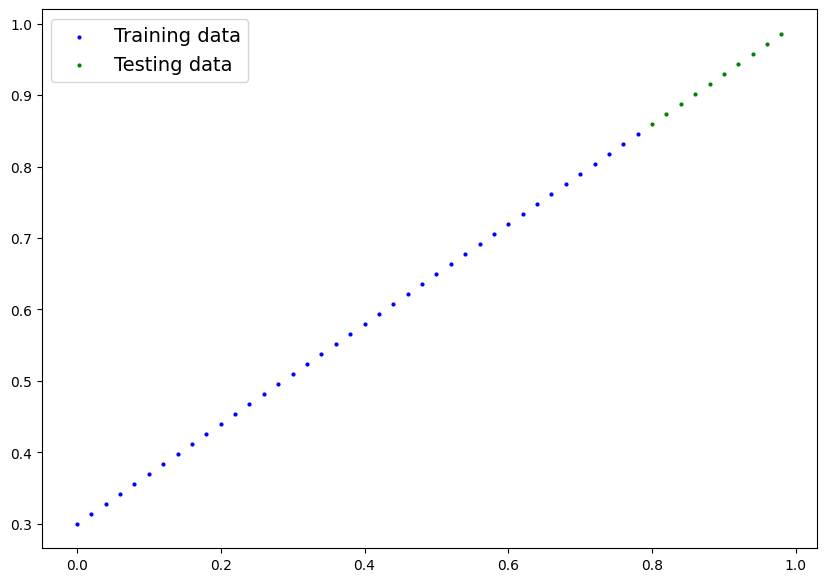

In [6]:
plot_predictions()

## 2. Build model
what the linear regression model does:
* start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

It uses two main algorithms:
1. Gradient descent
2. Backpropagation

Gradient descent:


In [7]:
from torch import nn

# Linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float))

  # Forward method to define the computation in the model
  def forward(self, x:torch.Tensor)->torch.Tensor:
    return self.weight * x + self.bias # linear regression formula


### PyTorch model essentials
* torch.nn - contains all buildings for neural networks
* torch.nn.Parameter - the parameters the model tries to learn
* torch.nn.Module - The base class for all neural network modules, if subclasseed, forword() method should be overwritten
* torch.optim - PyTorch optimizers.
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happns in the forward computation

### Checking the contents of the PyTorch model
Check model parameters using `.parameters()`


In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a sublcass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_model()`

To check the model's predictive power, we can see how well it predicts `y_test` based on `x_test`.
When we pass data trhough the model, it's going to run it through the `forward()` method.

In [10]:
# inputs and ideal outputs
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [11]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

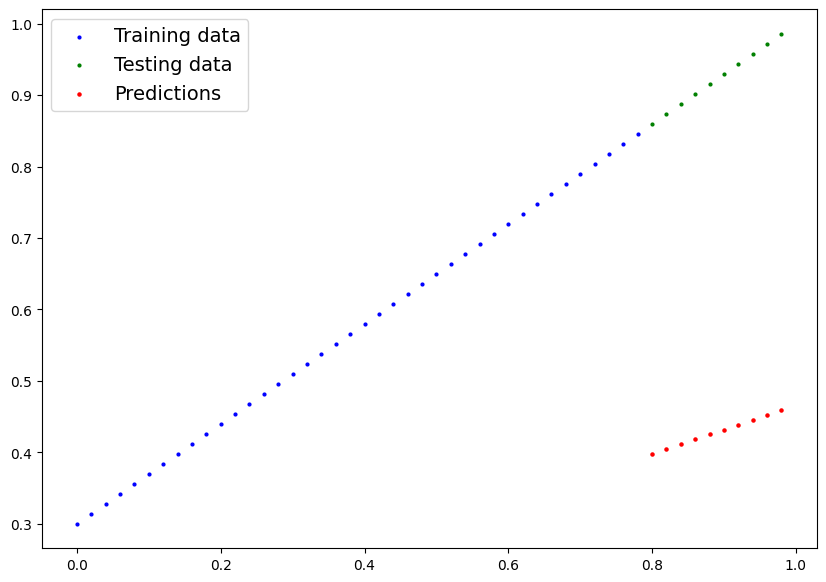

In [12]:
plot_predictions(predictions=y_preds)

## Train model

The whole idea is for a model to move from some *unknown* parameters (could be random) to some *known* parameters.

One way to measure how wrong the model predictions are is using a loss function.

* Note: loss functions are sometimes refered to as cost functions
* **Loss function**: A function to measure how wrong your model's predictions are, lower is better
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters(e.g. weight & bias)
  * Inside the optimizer there are two important parameters:
    * `params`- the model parameters you'd like to optimize, for example `params=model_0.parameters()`
    * `lr`(learning rate)- a hyper parameter that defines how big/small the optimzer changes the parameters with each step

PyTorch needs:
* A training loop
* A testing loop

In [13]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

#### Loss Functions
Measures how wrong the model is

Two common types of loss functions for regression are:
* Mean Absolute Error(MAE)
* Mean Square Error(MSE)

MAE measures absolute distance, MSE measures distance squared(better for error emphasis)

---
Mean Absolute Error

the average error-or distance between the predicted values and actual values.

MAE formula:
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
* n=total points
* $y_i$=actual value
* $\hat{y}_i$=predicted value

---

---
Mean Squared Error
the averaged squared error between predicted values and actual values

MSE formula:
$$
MSE = \frac{1}{n}\sum_{i+1}^{n}(y_i-\hat{y})^2
$$
* n=total points
* $y_i$=actual value
* $\hat{y}$=predicted value

---

#### nn.L1Loss()

PyTorch loss function that measures MAE between an input `x` and an ouput `y`

In [14]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent (SGD))
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.01) # learning rate is possibly the most important hyperparameters

### Training Loop and Testing Loop
training loop needs:
0. Loop through the data
1. Forward pass (this involves data moving through the model's `forward()` method(s)) - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust the model's parameters to try to improve the loss (**gradient descent**)

In [15]:
list(model_0.eval().parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

---
Training loop computes loss function and gradient descent on X_train (seen data) and then uses the updated parameters on X_test (unseen data)

---

In [16]:
# An epoch is one loop through the data (a hyperparameter)
epochs = 500

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training

# 0. Loop through the data
for epoch in range(epochs):
  model_0.train() # train mode in pytorch

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad() # zero the optimizer gradient since it accumulates every epoch, must zero them to start fresh each forward pass

  # 4. Backpropagation on the loss with respect to model parameters
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculmulate through the loop

  # Testing
  model_0.eval() # turns off unused settings in testing
  with torch.inference_mode():
    # 1. Forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred,y_test)

  # Print out training metrics every 10 epochs
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"EpochL: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    print(model_0.state_dict())


EpochL: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict({'weight': tensor([0.3406]), 'bias': tensor([0.1388])})
EpochL: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict({'weight': tensor([0.3796]), 'bias': tensor([0.2388])})
EpochL: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict({'weight': tensor([0.4184]), 'bias': tensor([0.3333])})
EpochL: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict({'weight': tensor([0.4512]), 'bias': tensor([0.3768])})
EpochL: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict({'weight': tensor([0.4748]), 'bias': tensor([0.3868])})
EpochL: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict({'weight': tensor([0.4938]), 'bias': tensor([0.3843])})
EpochL: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict({'weight': tensor([0.5116]), 'bias': tensor([0.3788])})
EpochL: 70 | Loss: 0.0

In [17]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [18]:
weight,bias

(0.7, 0.3)

/tmp/ipython-input-2023326738.py:2: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()),label="Train loss") # must convert from PyTorch to Numpy


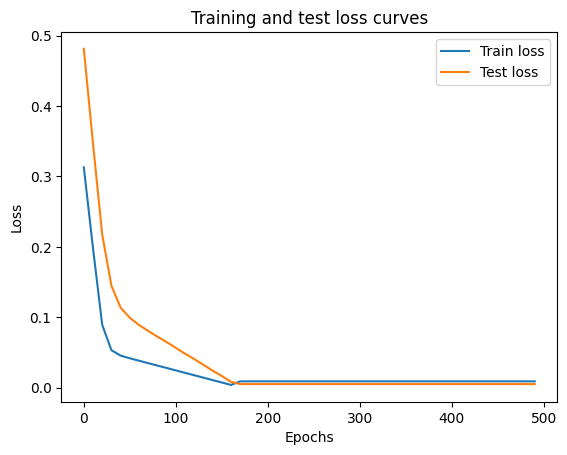

In [19]:
# Plot the loss curves
plt.plot(epoch_count,np.array(torch.tensor(loss_values).numpy()),label="Train loss") # must convert from PyTorch to Numpy
plt.plot(epoch_count,test_loss_values,label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [41]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
y_preds_new

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

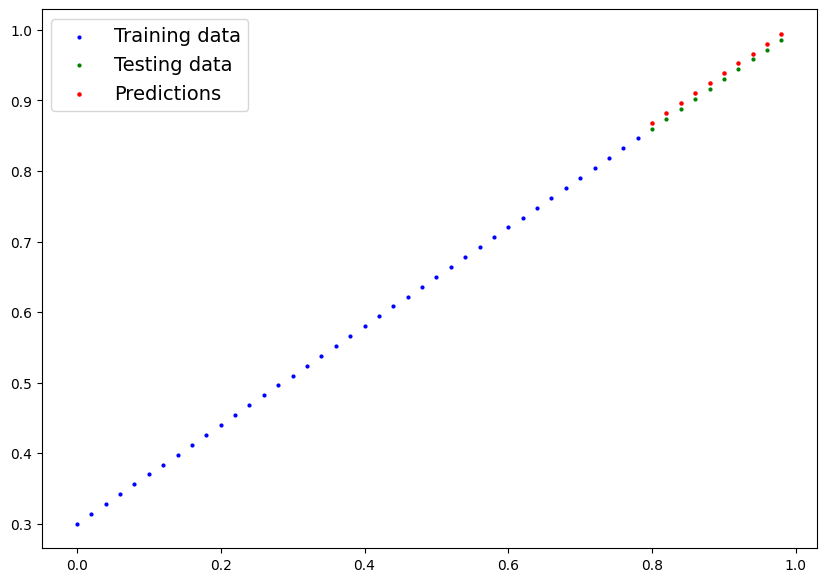

In [42]:
plot_predictions(predictions=y_preds_new)

## Save a model in PyTorch

Three main ways for saving and loading models in PyTorch
1. `torch.save()` - saves PyTorch object in Python's picke format
2. `torch.load()` - load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` loads a model's saved state dictionary

In [22]:
# Saving out PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_LinearRegression.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/01_LinearRegression.pth


In [23]:
!ls -l models

total 4
-rw-r--r-- 1 root root 1989 Aug 24 03:31 01_LinearRegression.pth


## Loading a PyTorch model

If you save only the model's `state_dict()` instead of the entire model, you can create a new instance of the model and load the `state_dict()` into that.

In [24]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [26]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [27]:
# make predictions with loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds=loaded_model_0(X_test)

In [43]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])